# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

data = pd.read_csv("data/train_clean.csv")
data.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


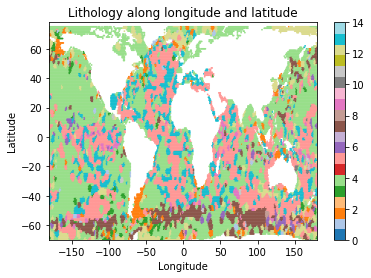

In [2]:
lon = data["longitude"].values
lat = data["latitude"].values
y = data["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

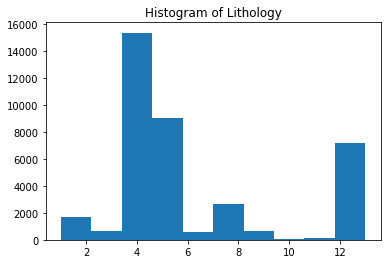

Unique class = [ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [3]:
# plot the histogram of lithology
plt.hist(y)
plt.title("Histogram of Lithology")
plt.show()
print("Unique class = {}".format(np.unique(y)))

In [4]:
training_data = data.copy()
if "longitude" in training_data or "latitude" in training_data:
    del training_data["longitude"]
    del training_data["latitude"]

# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# construct X and y 
X = training_data[features].as_matrix()
y = training_data[target].as_matrix()

print("Features = {}".format(features))

Features = ['bathymetry', 'nitrate', 'oxygen', 'phosphate', 'productivity', 'salinity', 'silicate', 'temperature']


### Neural Network Model

Use Aboleth to train a neural network model on training data

In [5]:
import tensorflow as tf
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import aboleth as ab

FRAC_TEST = 0.5
RSEED = 100
ab.set_hyperseed(RSEED)

# Optimization
NITER = 20000  # Training iterations per fold
BSIZE = 10  # mini-batch size
CONFIG = tf.ConfigProto(device_count={'GPU': 0})  # Use GPU ?
LSAMPLES = 1  # We're only using 1 dropout "sample" for learning to be more
PSAMPLES = 50  # Number of samples for prediction
REG = 0.001  # weight regularizer
NFEATURES = 8
NCLASSES = 13

rnd = np.random.RandomState(RSEED)
scale = rnd.rand(NFEATURES)
scale = scale[:, None]
lenscale = ab.pos(tf.Variable(scale, dtype=np.float32))

# Network structure
n_samples_ = tf.placeholder_with_default(LSAMPLES, [])
net = (
   ab.InputLayer(name='X', n_samples=n_samples_) >>
   ab.RandomArcCosine(n_features=NFEATURES, lenscale=lenscale) >>
   ab.RandomArcCosine(n_features=NFEATURES * 5, lenscale=lenscale * 5) >>
   ab.DenseVariational(output_dim=64) >>
   ab.Activation(tf.nn.relu) >>
   ab.DenseVariational(output_dim=NCLASSES)
)

X = training_data[features].values.astype(np.float32)
y = training_data[target].values.astype(np.float32)
Y = training_data[target].values.astype(np.float32) - 1
X = StandardScaler().fit_transform(X).astype(np.float32)
N, D = X.shape

# Split the training and testing data
ind_tr, ind_ts = train_test_split(
    range(len(X)),
    test_size=FRAC_TEST,
    random_state=RSEED)

X_tr, X_ts = X[ind_tr], X[ind_ts]
Y_tr, Y_ts = Y[ind_tr], Y[ind_ts]
N_tr, D = X_tr.shape

# Benchmark classifier
bcl = RandomForestClassifier(random_state=RSEED)

# Data
with tf.name_scope("Input"):
    X_ = tf.placeholder(dtype=tf.float32, shape=(None, D))
    Y_ = tf.placeholder(dtype=tf.float32, shape=(None,))

with tf.name_scope("Deepnet"):
    nn, kl = net(X=X_)
    lkhood = tf.distributions.Categorical(logits=nn)
    print(lkhood)
    loss = ab.elbo(lkhood, Y_, N_tr, kl)
    prob = ab.sample_mean(lkhood.probs)

    
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train = optimizer.minimize(loss)

# Launch the graph.
acc, acc_o, ll, ll_o = [], [], [], []
init = tf.global_variables_initializer()

with tf.Session(config=CONFIG):
    init.run()
    batches = ab.batch(
        {X_: X_tr, Y_: Y_tr},
        batch_size=BSIZE,
        n_iter=NITER
    )
    for i, data in enumerate(batches):
        train.run(feed_dict=data)
        if i % 1000 == 0:
            loss_val = loss.eval(feed_dict=data)
            print("Iteration {}, loss={}".format(i, loss_val))
    # prediction
    Ep = prob.eval(feed_dict={X_: X_ts, n_samples_: PSAMPLES})

/home/joyce/.virtualenvs/sea/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Iteration 0, loss=122260024.0
Iteration 1000, loss=1557891.75
Iteration 2000, loss=106682.046875
Iteration 3000, loss=39490.0625
Iteration 4000, loss=42717.0703125
Iteration 5000, loss=39010.9453125
Iteration 6000, loss=27926.9609375
Iteration 7000, loss=32712.9296875
Iteration 8000, loss=33086.20703125
Iteration 9000, loss=27615.693359375
Iteration 10000, loss=26374.302734375
Iteration 11000, loss=27645.60546875
Iteration 12000, loss=26769.1953125
Iteration 13000, loss=26355.0390625
Iteration 14000, loss=26266.52734375
Iteration 15000, loss=30982.85546875
Iteration 16000, loss=28557.15625
Iteration 17000, loss=22425.416015625
Iteration 18000, loss=22464.044921875
Iteration 19000, loss=21809.951171875


0.465072273325


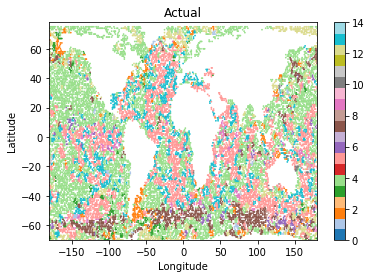

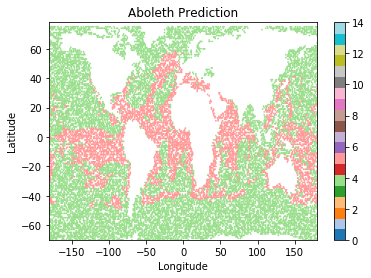

In [6]:
Ey = Ep.argmax(axis=1)
print(accuracy_score(Y_ts, Ey))
draw_global(lon[ind_ts], lat[ind_ts], Y_ts + 1, "Actual")
draw_global(lon[ind_ts], lat[ind_ts], Ey + 1, "Aboleth Prediction")

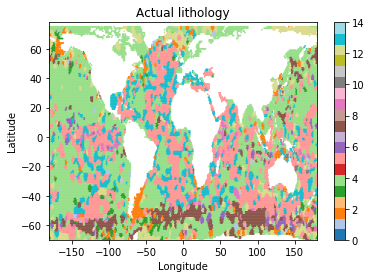

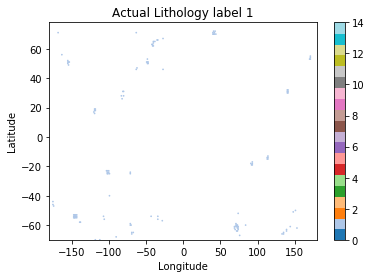

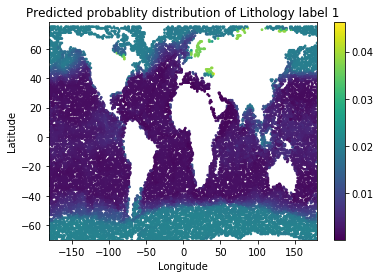

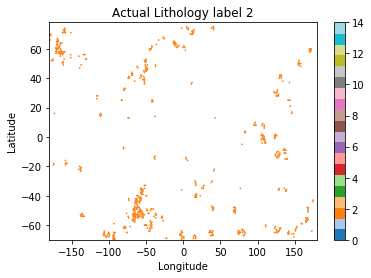

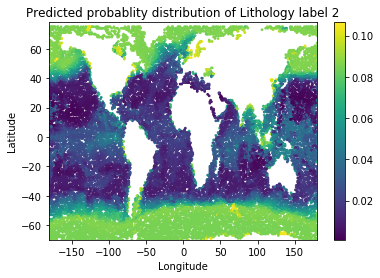

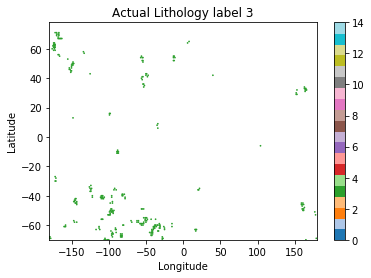

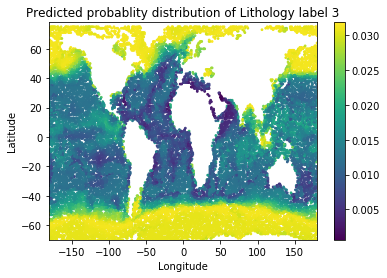

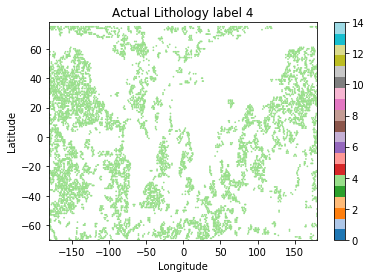

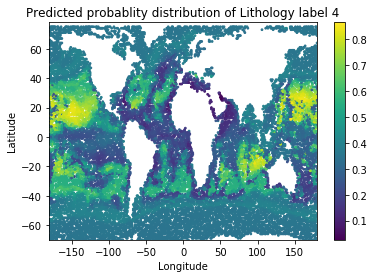

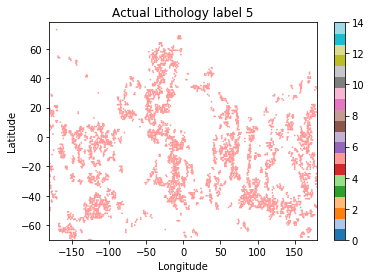

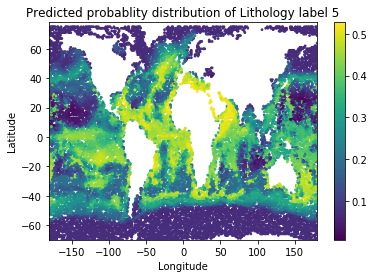

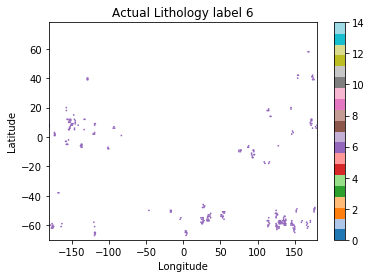

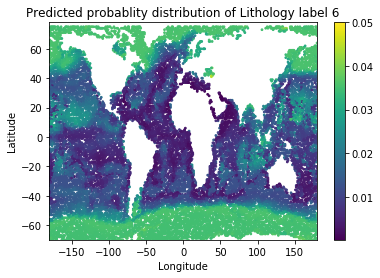

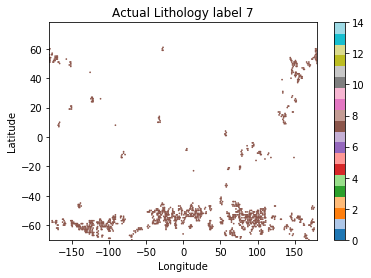

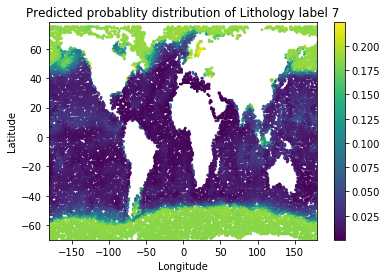

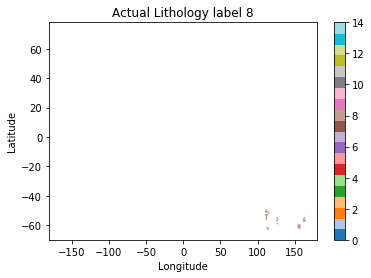

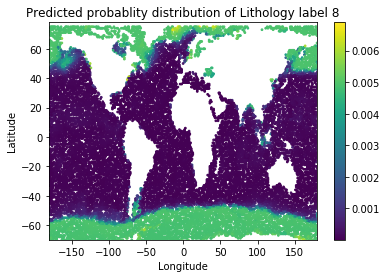

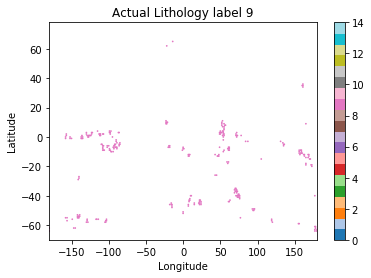

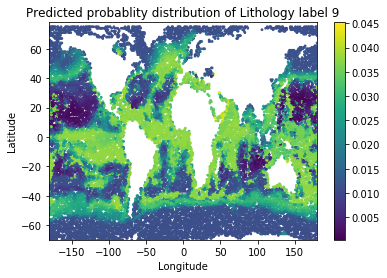

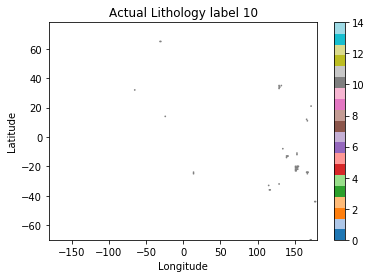

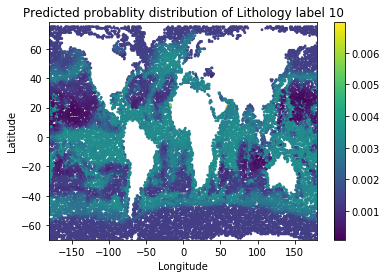

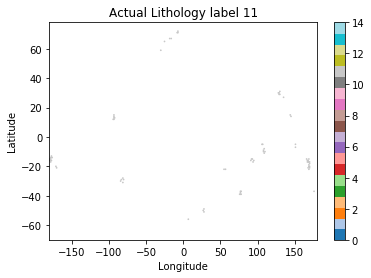

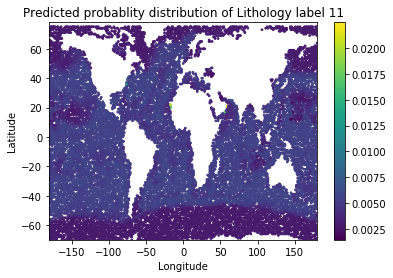

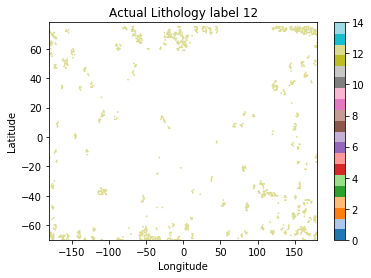

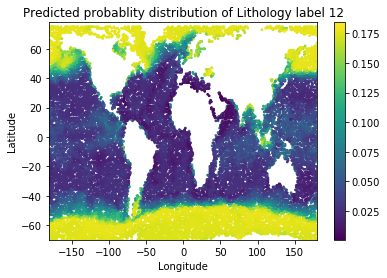

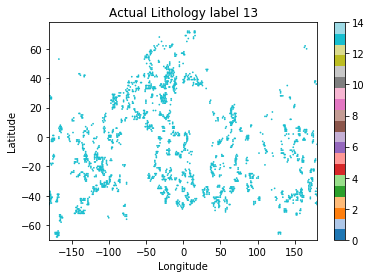

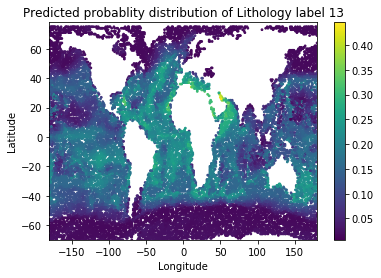

In [7]:
draw_global(lon, lat, y, "Actual lithology")

def draw_prob(lon, lat, p, title, size=3):
    sc = plt.scatter(lon, lat, s=size, c=p)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
    plt.close()
    

for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y_ts == i
    thisY = Y_ts[Y_ts == i] + 1
    draw_global(lon[ind_ts][index], lat[ind_ts][index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon[ind_ts], lat[ind_ts], p = Ep[:,i], title=title_p)

In [8]:
# import aboleth as ab
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, log_loss

# FRAC_TEST = 0.5
# NFEATURES = 8
# NCLASSES = 13
# METHOD = "LearnedNormalImpute"
# NEPOCH = 5
# BSIZE = 100
# LSAMPLES = 5  # training
# PSAMPLES = 50 # prediction
# REG = 0.001
# RSEED = 100
# ab.set_hyperseed(RSEED)
# CONFIG = tf.ConfigProto(device_count={'GPU': 0})
# NITER = 20000

# # network construction
# n_samples_ = tf.placeholder_with_default(LSAMPLES, [])
# rnd = np.random.RandomState(RSEED)
# scale = rnd.rand(NFEATURES)[:, None]
# lenscale = ab.pos(tf.Variable(scale, dtype=np.float32))

# net = ab.stack(
#     ab.InputLayer(name="X", n_samples=n_samples_),
#     ab.RandomArcCosine(n_features=NFEATURES, lenscale=lenscale),
#     ab.DropOut(0.95),
#     ab.DenseVariational(output_dim=64),
#     ab.Activation(h=tf.nn.relu),
#     ab.DropOut(0.5),
#     ab.DenseVariational(output_dim=64),
#     ab.Activation(h=tf.nn.relu),
#     ab.DropOut(0.5),
#     ab.DenseVariational(output_dim=NCLASSES)
# )

# # data input
# X = training_data[features].values.astype(np.float32)
# y = training_data[target].values.astype(np.float32)
# Y = training_data[target].values.astype(np.float32) - 1
# X = StandardScaler().fit_transform(X).astype(np.float32)
# N, D = X.shape

# # Split the training and testing data
# ind_tr, ind_ts = train_test_split(
#     range(len(X)),
#     test_size=FRAC_TEST,
#     random_state=RSEED)

# X_tr, X_ts = X[ind_tr], X[ind_ts]
# Y_tr, Y_ts = Y[ind_tr], Y[ind_ts]
# N_tr, D = X_tr.shape

# # Data
# with tf.name_scope("Input"):
#     X_ = tf.placeholder(dtype=tf.float32, shape=(None, D))
#     Y_ = tf.placeholder(dtype=tf.float32, shape=(None,))

# with tf.name_scope("Deepnet"):
#     nn, kl = net(X=X_)
#     lkhood = tf.distributions.Categorical(logits=nn)
#     loss = ab.elbo(lkhood, Y_, N_tr, kl)
#     prob = ab.sample_mean(lkhood.probs)

    
# with tf.name_scope("Train"):
#     optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
#     train = optimizer.minimize(loss)

# # Launch the graph.
# acc, acc_o, ll, ll_o = [], [], [], []
# init = tf.global_variables_initializer()

# with tf.Session(config=CONFIG):
#     init.run()
#     batches = ab.batch(
#         {X_: X_tr, Y_: Y_tr},
#         batch_size=BSIZE,
#         n_iter=NITER
#     )
#     for i, data in enumerate(batches):
#         train.run(feed_dict=data)
#         if i % 1000 == 0:
#             loss_val = loss.eval(feed_dict=data)
#             print("Iteration {}, loss={}".format(i, loss_val))
#     # prediction
#     Ep = prob.eval(feed_dict={X_: X_ts, n_samples_: PSAMPLES})